Something that I think I missed reading through this that would have been VERY helpful from the onset (assuming I'm thinking about this correctly):
-- LangGraph processes 1 message per graph run/cycle. The point of the framework is to manage the next steps that happen beyond each user's message.
-- LangGraph's state persists between messages, or between graph cycles. This is the reason for the checkpointer/thread system, to manage & update state between graph runs/cycles. Each graph run/cycle can also update the graph mid-run/cycle.

As simple as it sounds, this was an assumption that I completely missed reading the docs again early on and caused a lot of headache getting started.



In [76]:
import os
from dotenv import load_dotenv


from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

from IPython.display import Image, display

from langchain_google_community import GoogleSearchAPIWrapper
from langchain_core.tools import Tool, tool, InjectedToolCallId

from langchain_community.tools.tavily_search import TavilySearchResults

from langchain_core.messages import ToolMessage, SystemMessage, HumanMessage, AIMessage
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.checkpoint.memory import MemorySaver

from langgraph.types import Command, interrupt

In [2]:
load_dotenv("../.env")

True

## Simple chatbot using LangGraph

In [3]:
llm = ChatOpenAI(
    model_name="gpt-4o-mini",
    temperature=0,
    openai_api_key=os.getenv
        ("OPENAI_API_KEY"),
)

In [ ]:


class State(TypedDict):
    messages: Annotated[list, add_messages]
    
graph_builder = StateGraph(State)

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

In [34]:
graph_builder.add_node("chatbot", chatbot)

In [35]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

In [36]:
graph = graph_builder.compile()

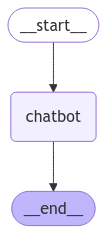

In [37]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [38]:
# def stream_graph_updates(user_input: str):
#     for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
#         for value in event.values():
#             print(value)
#             print("Assistant:", value["messages"][-1].content)


# while True:
#     try:
#         user_input = input("User: ")
#         if user_input.lower() in ["quit", "exit", "q"]:
#             print("Goodbye!")
#             break
#         stream_graph_updates(user_input)
#     except:
#         # fallback if input() is not available
#         user_input = "What do you know about LangGraph?"
#         print("User: " + user_input)
#         stream_graph_updates(user_input)
#         break

In [39]:
def stream_graph_updates(user_input: str):
    print("User:", user_input)  # Print user input
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [40]:

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: hi
Assistant: Hello! How can I assist you today?
Goodbye!


## With Search Tool to look up Internet

In [41]:
# Google Search
# search = GoogleSearchAPIWrapper(
#     google_api_key=os.getenv("GOOGLE_API_KEY"),
#     google_cse_id=os.getenv("GOOGLE_CSE_ID"),
#     k=3
# )
# search_tool = Tool(
#     name="google_search",
#     description="Search google for recent results.",
#     func=search.run,
# )

# Tavily Search
search_tool = TavilySearchResults(
    max_results=3,
    tavily_api_key=os.getenv("TAVILY_API_KEY"),
)

In [42]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [43]:
llm_with_tools = llm.bind_tools([search_tool])

def chatbot(state:State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [44]:
# building tool node
tool_node = ToolNode(tools=[search_tool])

In [45]:
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge(START, "chatbot")

graph_builder.add_conditional_edges("chatbot", tools_condition, )

graph_builder.add_edge("tools", "chatbot")

graph = graph_builder.compile()

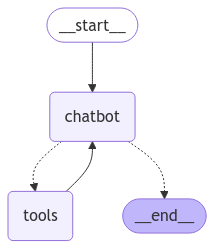

In [46]:
display(Image(graph.get_graph().draw_mermaid_png()))


In [48]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: hi
Assistant: Hello! How can I assist you today?
User: my name is kuldeep
Assistant: Hello Kuldeep! How can I assist you today?
User: what is my name
Assistant: I don't have access to personal data about users unless it has been shared with me in the course of our conversation. Therefore, I don't know your name. If you'd like to share it, feel free!
User: there?
Assistant: Yes, I'm here! How can I assist you today?
User: ?
Assistant: It seems like your message is incomplete. How can I assist you today?
User: 
Assistant: Hello! How can I assist you today?
Goodbye!


# With Search Tool and Memory

In [52]:
search_tool = TavilySearchResults(
    max_results=3,
    tavily_api_key=os.getenv("TAVILY_API_KEY"),
)

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

memory = MemorySaver()

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition, )
graph_builder.add_edge("tools", "chatbot")

graph = graph_builder.compile(checkpointer=memory)

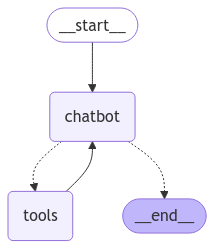

In [54]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [55]:
config = {"configurable": {"thread_id": "1"}}

In [56]:
user_input = "Hi, there my name is Kuldeep."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, there my name is Kuldeep.
================================== Ai Message ==================================

Hello Kuldeep! How can I assist you today?


In [57]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember your name, Kuldeep! How can I help you today?


In [58]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I don't have the ability to remember personal information or previous interactions. However, I'm here to help you with any questions or topics you'd like to discuss!


In [64]:
snapshot = graph.get_state(config)
snapshot, snapshot.next

(StateSnapshot(values={'messages': [HumanMessage(content='Hi, there my name is Kuldeep.', additional_kwargs={}, response_metadata={}, id='f0ba721e-6904-456c-8551-cd5033b47cd9'), AIMessage(content='Hello Kuldeep! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 88, 'total_tokens': 101, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_13eed4fce1', 'finish_reason': 'stop', 'logprobs': None}, id='run-60bd8f65-9879-44fb-93ef-0440715c3f06-0', usage_metadata={'input_tokens': 88, 'output_tokens': 13, 'total_tokens': 101, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='Remember my name?', additional_

# with human assistance

In [4]:
search_tool = TavilySearchResults(
    max_results=2,
    tavily_api_key=os.getenv("TAVILY_API_KEY")
)


@tool
def human_assistance(query: str) -> str:
    """Request assitance from human."""
    human_response = interrupt({"query": query})
    return human_response["data"]


tools = [search_tool, human_assistance]

llm_with_tools = llm.bind_tools(tools)

In [5]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

In [7]:
tool_node = ToolNode(tools=tools)

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition, )
graph_builder.add_edge("tools", "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

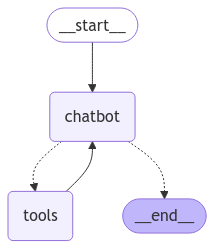

In [8]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_egXE6UG2HAlTGc3jyTRJGDVx)
 Call ID: call_egXE6UG2HAlTGc3jyTRJGDVx
  Args:
    query: I need expert guidance for building an AI agent. Can you provide insights on the best practices, tools, and frameworks to use?


In [10]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_egXE6UG2HAlTGc3jyTRJGDVx)
 Call ID: call_egXE6UG2HAlTGc3jyTRJGDVx
  Args:
    query: I need expert guidance for building an AI agent. Can you provide insights on the best practices, tools, and frameworks to use?
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

For building an AI agent, it's recommended to check out **LangGraph**. It is considered more reliable and extensible compared to simple autonomous agents. If you need further details or specific guidance on using LangGraph or other tools, feel free to ask!


## With Customized State

In [38]:
@tool
# Note that because we are generating a ToolMessage for a state update, we
# generally require the ID of the corresponding tool call. We can use
# LangChain's InjectedToolCallId to signal that this argument should not
# be revealed to the model in the tool's schema.
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    # We return a Command object in the tool to update our state.
    return Command(update=state_update)

search_tool = TavilySearchResults(
    max_results=2,
    tavily_api_key=os.getenv("TAVILY_API_KEY")
)
tools = [search_tool, human_assistance]

llm_with_tools = llm.bind_tools(tools)
tool_node = ToolNode(tools=tools)

In [39]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday : str

In [40]:
def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition, )
graph_builder.add_edge("tools", "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [46]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_r6pA77phsYyz74XvNcp5xyG6)
 Call ID: call_r6pA77phsYyz74XvNcp5xyG6
  Args:
    query: LangGraph release date
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://pypi.org/project/langgraph/", "content": "LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. The simplest way to create a tool-calling agent in LangGraph is to use create_react_agent: # Define the tools for the agent to use # Define the tools for the agent to use # This means that after `tools` is called, `agent` node is called next. workflow.add_edge(\"t

In [42]:
# human_command = Command(
#     resume={
#         "correct": "yes",
#     },
# )

# events = graph.stream(human_command, config, stream_mode="values")
# for event in events:
#     if "messages" in event:
#         event["messages"][-1].pretty_print()

human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_G91AT0ZdrPDyJ9znxnRh4nK7)
 Call ID: call_G91AT0ZdrPDyJ9znxnRh4nK7
  Args:
    name: LangGraph
    birthday: February 6, 2025
================================= Tool Message =================================
Name: human_assistance

Made a correction: {'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}
================================== Ai Message ==================================

LangGraph was released on January 17, 2024.


In [43]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}


{'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}

In [45]:
{k: v for k, v in snapshot.values.items() if k not in ("name", "birthday")}

{'messages': [HumanMessage(content='Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.', additional_kwargs={}, response_metadata={}, id='815a57a9-af48-421b-bea3-a7f04f344bae'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1mOqKXlOh7ogw85zOzf6TQ4B', 'function': {'arguments': '{"query":"LangGraph release date"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 129, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-af37a6fc-002e-442e-8076-83b74aced081-0', tool_calls=[{'name': 'tavily_sear

## Time Travel

In [59]:
search_tool = TavilySearchResults(
    max_results=3,
    tavily_api_key=os.getenv("TAVILY_API_KEY"),
)

tools = [search_tool]

In [60]:
def chatbot(state: State):
    message = llm.invoke(state["messages"])
    return {"messages": [message]}

tool_node = ToolNode(tools=tools)

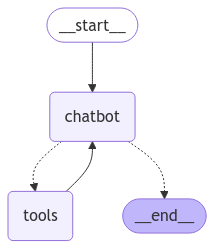

In [61]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

memory = MemorySaver()

graph_builder = StateGraph(State)



graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition, )
graph_builder.add_edge("tools", "chatbot")

graph = graph_builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [62]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "I'm learning LangGraph. "
                    "Could you do some research on it for me?"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================

As of my last knowledge update in October 2023, LangGraph is a framework designed to facilitate the development of applications that leverage large language models (LLMs) and graph-based data structures. It aims to combine the strengths of LLMs in natural language understanding and generation with the structured representation of knowledge that graphs provide.

### Key Features of LangGraph:

1. **Integration of LLMs and Graphs**: LangGraph allows developers to create applications that can process and generate natural language while also utilizing graph-based data for more structured reasoning and knowledge representation.

2. **Knowledge Representation**: By using graphs, LangGraph can represent complex relationships and entities, making it easier to perform t

In [63]:
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Ya that's helpful. Maybe I'll "
                    "build an autonomous agent with it!"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

That sounds like an exciting project! Building an autonomous agent using LangGraph can open up a lot of possibilities, especially in terms of natural language interaction and knowledge management. Here are some ideas and considerations to help you get started:

### Ideas for an Autonomous Agent:

1. **Personal Assistant**: Create an agent that can manage tasks, schedule appointments, and provide reminders, all while understanding and responding to natural language queries.

2. **Customer Support Bot**: Develop an agent that can handle customer inquiries, provide information about products or services, and escalate issues to human agents when necessary.

3. **Knowledge Retrieval Agent**: Build an agent that can answer questions based on a specific knowledge base

In [67]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 3:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  0 Next:  ('__start__',)
--------------------------------------------------------------------------------


In [68]:
print(to_replay.next)
print(to_replay.config)

('chatbot',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efef15a-9711-6883-8003-e83e78accf8c'}}


In [69]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

That sounds like an exciting project! Building an autonomous agent using LangGraph can open up a lot of possibilities, especially in terms of natural language interaction and knowledge management. Here are some ideas and considerations to help you get started:

### Ideas for an Autonomous Agent:

1. **Personal Assistant**: Create an agent that can manage tasks, schedule appointments, and provide reminders, all while understanding and responding to natural language queries.

2. **Customer Support Bot**: Develop an agent that can handle customer inquiries, provide information about products or services, and escalate issues to human agents when necessary.

3. **Knowledge Retrieval Agent**: Build an agent that can answer questions based on a specific knowledge base

In [58]:
state

StateSnapshot(values={'messages': []}, next=('__start__',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efef155-585c-6ff0-bfff-3d441873a51e'}}, metadata={'source': 'input', 'writes': {'__start__': {'messages': [{'role': 'user', 'content': "I'm learning LangGraph. Could you do some research on it for me?"}]}}, 'thread_id': '1', 'step': -1, 'parents': {}}, created_at='2025-02-19T23:00:37.995912+00:00', parent_config=None, tasks=(PregelTask(id='04efd6b9-0989-9633-aac8-ca24a5213210', name='__start__', path=('__pregel_pull', '__start__'), error=None, interrupts=(), state=None, result={'messages': [{'role': 'user', 'content': "I'm learning LangGraph. Could you do some research on it for me?"}]}),))

## Interviewer

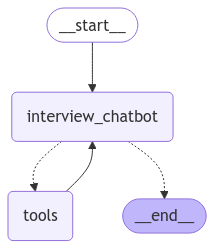

In [75]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command, interrupt
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool, InjectedToolCallId
from langchain_core.messages import ToolMessage
from typing import Annotated
from typing_extensions import TypedDict

# Define the state
class InterviewState(TypedDict):
    messages: Annotated[list, add_messages]
    interview_data: dict

# Initialize the LLM
llm = ChatOpenAI(
    model_name="gpt-4o-mini",
    temperature=0,
    openai_api_key=os.getenv("OPENAI_API_KEY"),
)

# Define the chatbot function
def interview_chatbot(state: InterviewState):
    message = llm.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

# Define the human assistance tool
@tool
def human_assistance(question: str, tool_call_id: Annotated[str, InjectedToolCallId]) -> str:
    """To take response from a user"""
    human_response = interrupt({"question": question})
    response = human_response["data"]
    state_update = {
        "interview_data": {question: response},
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    return Command(update=state_update)

# Initialize the tools
tools = [human_assistance]
llm_with_tools = llm.bind_tools(tools)
tool_node = ToolNode(tools=tools)

# Build the graph
graph_builder = StateGraph(InterviewState)
graph_builder.add_node("interview_chatbot", interview_chatbot)
graph_builder.add_node("tools", tool_node)
graph_builder.add_edge(START, "interview_chatbot")
graph_builder.add_conditional_edges("interview_chatbot", tools_condition)
graph_builder.add_edge("tools", "interview_chatbot")

# Initialize memory
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Display the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [77]:
system_message = SystemMessage(content="You are an interviewer conducting a job interview. Ask questions to candidates one by one.")
graph.update_state(config, {"messages": [system_message]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efef194-c2aa-6a86-8000-f7a3bfa3d602'}}

In [78]:
# Function to stream graph updates
def stream_graph_updates(user_input: str):
    print("User:", user_input)
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

# Start the interview
user_input = "I am ready to give interview. Please start with the first question."
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I am ready to give interview. Please start with the first question.
================================== Ai Message ==================================

Great! Let's get started. 

1. Can you please tell me a little about yourself and your professional background?


In [79]:
user_input = ("Sure, I am Kuldeep Singh, I have a Bachelor's degree in Computer Science and 3 years of experience in software development. ")
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Sure, I am Kuldeep Singh, I have a Bachelor's degree in Computer Science and 3 years of experience in software development. 
================================== Ai Message ==================================

Thank you, Kuldeep. It's nice to meet you! 

2. Can you describe a project you worked on that you are particularly proud of? What was your role, and what technologies did you use?


In [ ]:
user_input = ("Sure, I am Kuldeep Singh, I have a Bachelor's degree in Computer Science and 3 years of experience in software development. ")
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()